# 1 and 2: Preparation and Data Set

In [21]:
# Task 2: Data Set
# Description: An array of possible binary inputs is defined as x. 
#              Moreover the targets, t, for the logical gates: and, or, not and, not or and exclusive or (xor) are defined.
#              Additionally, functions for the activation function (sigmoid) and its derivative (sigmoidprime) is written down here, 
#              so you could easily change it to different functions if necessary.

import numpy as np 

inputs = np.array([[0,0],[0,1],[1,0],[1,1]])

target_and = np.array([0,0,0,1])
target_or = np.array([0,1,1,1])
target_nand = np.array([1,1,1,0])
target_nor = np.array([1,0,0,0])
target_xor = np.array([0,1,1,0])


def sigmoid(x): 
    return (1 / (1 + np.exp(-x)))


def sigmoidprime(x):
    return (sigmoid(x) * (1 - sigmoid(x)))

# 3: Perceptron class

In [22]:
# Task 3: Perceptron
# Description: The class Perceptron describes the behavior of a single neuron, there fore it includes:
#              @init variables: input_units
#              @class variables: -
#              @object variables: _input_units, _weights, _bias, _alpha, _drive, _activations_previous_layer
#              @functions: forward_step, update, _get_drive, _get_weights

class Perceptron:
    
    def __init__(self, input_units):
        self._input_units = input_units
        self._weights = np.random.randn(input_units)
        self._bias = np.random.randn()
        self._alpha = 1
        self._drive = 0
        
        #Array to save the activations of the previous layer (In case of the first hidden layer the inputs of the MLP). 
        self._activations_previous_layer = np.empty(input_units)
 

    # Description: This function conducts one forward step of a perceptron. 
    #              Therefore it calculates the output with the activation function depending on the input. 
    #              Moreover the input is saved in the object variable _activations_previous_layer, cause its needed for the backpropagation later on.
    #              @init variables: inputs
    def forward_step(self, inputs):
        self._activations_previous_layer = inputs
        self._drive = np.dot(inputs, self._weights) + self._bias 
        activation = sigmoid(self._drive)
        return activation             
 

    # Description: This function updates the weights and bias of the perceptron, using general functions from courseware/homework. 
    #              @init variables: delta
    def update(self, delta):
        self._weights -= self._alpha * delta * self._activations_previous_layer
        self._bias -= self._alpha * delta * 1
 

    def _get_drive(self):
        return self._drive
    
    
    def _get_weights(self):
        return self._weights

# 4: Multi-Layer Perceptron class

In [23]:
# Task 4: Multi-Layer Perceptron
# Description: The class MLP describes a multi-layer perceptron with one hidden layer and one output perceptron.
#              When creating a MLP, the number of perceptrons in the hidden layer - the size - and the number of inputs need to be defined.
#              @init variables: input_units, size_hidden_layer
#              @class variables: -
#              @object variables: _size_hidden_layer, _hidden_layer[]
#              @functions: forward_step, backprop_step

class MLP:
    
    def __init__(self, input_units, size_hidden_layer):
        self._size_hidden_layer = size_hidden_layer
        self._hidden_layer = [None for i in range(size_hidden_layer)]
        for i in range(self._size_hidden_layer):
            self._hidden_layer[i] = Perceptron(input_units)
        
        self._output_layer = Perceptron(size_hidden_layer)

        
    # Description: This function conducts one forward step of a multi-layer perceptron. 
    #              Therefore it computes first the activation of the hidden layer and sencondly the overall output from the output layer.
    #              @init variables: inputs
    def forward_step(self, inputs): 
        activations_hidden_layer = np.empty(self._size_hidden_layer)
        for i in range(self._size_hidden_layer):
            activations_hidden_layer[i] = self._hidden_layer[i].forward_step(inputs)
            
        output = self._output_layer.forward_step(activations_hidden_layer)
        
        return output

    
    # Description: This function conducts the backpropagation of the whole multi-layer perceptron. 
    #              Therefore it computes first the delta of the output layer, secondly the delta of the perceptrons from the hidden layer.
    #              Moreover, it calculates the delta and the loss function and then updates all perceptrons from hidden and output layer.
    #              @init variables: derivative_loss
    def backprop_step(self, derivative_loss):
        delta_output_layer = derivative_loss * sigmoidprime(self._output_layer._get_drive())
        
        # Calculates the first part of the loss function, givin in the homework task, hint 9.
        weighted_delta_output_layer = delta_output_layer * self._output_layer._get_weights()
        
        deltas_hidden_layer = np.empty(self._size_hidden_layer)
        for i in range(self._size_hidden_layer):             
            deltas_hidden_layer[i] = weighted_delta_output_layer[i] * sigmoidprime(self._hidden_layer[i]._get_drive())
        
        self._output_layer.update(delta_output_layer) 
        
        # Update of hidden layer could also be possible in the for-loop before, 
        # but to better represent the correct order of backpropagation there is another for-loop here.
        for i in range(self._size_hidden_layer):
            self._hidden_layer[i].update(deltas_hidden_layer[i])
        

# 5: Training

In [24]:
# Task 5: Training
# Description: The following steps create a multi-layer perceptron with a hidden layer consisting of 4 perceptrons.
#              Moreover, the target and the input is defined, regarding the definitions from Task 2 - see above.
#              Secondly, a training loop, trains the multi-layer perceptron to a target and calculates the accuracy of the
#              multi-layer perceptron. Therefore, it performs the backpropagation of the multi-layer perceptron and compares
#              the output of the multi-layer perceptron with the target using the error term givin in Task 5.

target = target_xor    

size_hidden_layer = 4
logical_gate = MLP(2, size_hidden_layer)

amount_of_training_epochs = 1000

steps = np.empty(amount_of_training_epochs)
average_accuracy_each_epoch = np.empty(amount_of_training_epochs)
average_loss_each_epoch = np.empty(amount_of_training_epochs)

# Training Loop:
for epoch in range(amount_of_training_epochs):
    steps[epoch] = epoch
    correct_output_current_epoch = 0
    loss_current_epoch = 0
    
    for i in range(len(inputs)):
        output = logical_gate.forward_step(inputs[i])
    
        # Compare output and target
        if (output <= 0.5 and target[i] == 0) or (output > 0.5 and target[i] == 1):
            correct_output_current_epoch += 1
    
        # Calculate loss and do backpropagation
        loss_current_epoch += np.square(target[i] - output)    
        derivative_loss = -2 * (target[i] - output)
    
        logical_gate.backprop_step(derivative_loss)
    
    #Update accuracy and loss arrays.
    average_accuracy_each_epoch[epoch] = correct_output_current_epoch / len(inputs)
    average_loss_each_epoch[epoch] = loss_current_epoch / len(inputs) 

# 6: Visualization

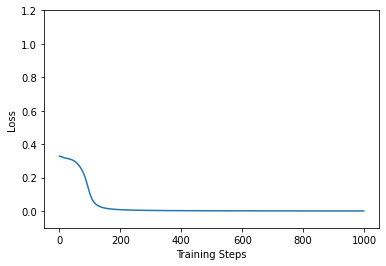

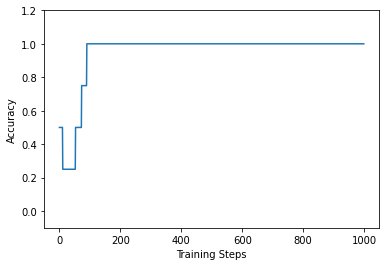

In [25]:
# Task 6: Visualization
# Description: Figure 1 shows the average of the loss over all backpropagation steps.
#              Figure 2 shows the accuracy of the multi-layer perceptron over all backpropagation steps.

import matplotlib.pyplot as plt

plt.figure()
plt.plot(steps, average_loss_each_epoch)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.ylim([-0.1, 1.2])
plt.show()

plt.figure()
plt.plot(steps, average_accuracy_each_epoch)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.2])
plt.show()